In [1]:
from __future__ import print_function
import torch, os, gym, time, glob, argparse, sys
import numpy as np
from scipy.signal import lfilter
from scipy.misc import imresize # preserves single-pixel info _unlike_ img = img[::2,::2]
import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing as mp

In [2]:
class NNPolicy(torch.nn.Module): # an actor-critic neural network
    def __init__(self, channels, num_actions):
        super(NNPolicy, self).__init__()
        self.conv1 = nn.Conv2d(channels, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        self.lstm = nn.LSTMCell(32 * 5 * 5, 256)
        self.critic_linear, self.actor_linear = nn.Linear(256, 1), nn.Linear(256, num_actions)

    def forward(self, inputs):
        inputs, (hx, cx) = inputs
        x = F.elu(self.conv1(inputs))
        x = F.elu(self.conv2(x))
        x = F.elu(self.conv3(x))
        x = F.elu(self.conv4(x))
        x = x.view(-1, 32 * 5 * 5)
        hx, cx = self.lstm(x, (hx, cx))
        return self.critic_linear(hx), self.actor_linear(hx), (hx, cx)

    def try_load(self, save_dir, checkpoint='*.tar'):
        paths = glob.glob(save_dir + checkpoint) ; step = 0
        if len(paths) > 0:
            ckpts = [int(s.split('.')[-2]) for s in paths]
            ix = np.argmax(ckpts) ; step = ckpts[ix]
            self.load_state_dict(torch.load(paths[ix]))
        print("\tno saved models") if step is 0 else print("\tloaded model: {}".format(paths[ix]))
        return step

In [3]:
from torch.autograd import Variable
prepro = lambda img: imresize(img[35:195].mean(2), (80,80)).astype(np.float32).reshape(1,80,80)/255.

In [7]:
save_dir ="weights/"
env = gym.make('Breakout-v4')
num_actions = env.action_space.n # get the action space of this game
prepro = lambda img: imresize(img[35:195].mean(2), (80,80)).astype(np.float32).reshape(1,80,80)/255.


model = NNPolicy(channels=1, num_actions=num_actions)
model.try_load(save_dir)
hx, cx = Variable(torch.zeros(1, 256)), Variable(torch.zeros(1, 256))
state = env.reset()

	loaded model: weights/strong.40.tar


In [5]:
done = False
while not done:
    state = torch.tensor(prepro(state))
    value, logit, (hx, cx) = model((state.view(1,1,80,80), (hx, cx)))
    logp = F.log_softmax(logit, dim=-1)
    action = torch.exp(logp).multinomial(num_samples=1).data[0]
    state, reward, done, info = env.step(action.numpy()[0])
    env.render()
env.close()

/home/david/anaconda3/envs/Pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


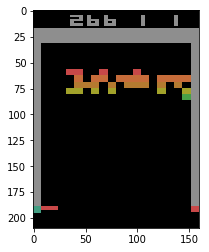

In [8]:
from IPython import display
import matplotlib
import matplotlib.pyplot as plt

state = env.reset()
img = plt.imshow(state)
done = False
 # only call this once
while not done:
    state = torch.tensor(prepro(state))
    value, logit, (hx, cx) = model((state.view(1,1,80,80), (hx, cx)))
    logp = F.log_softmax(logit, dim=-1)
    action = torch.exp(logp).multinomial(num_samples=1).data[0]
    state, reward, done, info = env.step(action.numpy()[0])
    img.set_data(state) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)

    if done:
        break

## GradCam

In [34]:
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255*mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    #cv2.imwrite("cam.jpg", np.uint8(255 * cam))
    return cam

In [ ]:
class ModelOutputs():
	""" Class for making a forward pass, and getting:
	1. The network output.
	2. Activations from intermeddiate targetted layers.
	3. Gradients from intermeddiate targetted layers. """
	def __init__(self, model, target_layers):
		self.model = model
		self.feature_extractor = FeatureExtractor(self.model.features, target_layers)

	def get_gradients(self):
		return self.feature_extractor.gradients

	def __call__(self, x):
		target_activations, output  = self.feature_extractor(x)
		output = output.view(output.size(0), -1)
		output = self.model.classifier(output)
		return target_activations, output


In [38]:
class GradCam:
    def __init__(self, model, target_layer_names, use_cuda=False):
        self.model = model
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        self.extractor = ModelOutputs(self.model, target_layer_names)

    def forward(self, input):
        return self.model(input) 

    def __call__(self, input, index = None):
        if self.cuda:
            features, output = self.extractor(input.cuda())
        else:
            features, output = self.extractor(input)

        if index == None:
            index = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype = np.float32)
        one_hot[0][index] = 1
        one_hot = Variable(torch.from_numpy(one_hot), requires_grad = True)
        if self.cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
        else:
            one_hot = torch.sum(one_hot * output)

        self.model.features.zero_grad()
        self.model.classifier.zero_grad()
        one_hot.backward(retain_variables=True)

        grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()

        target = features[-1]
        target = target.cpu().data.numpy()[0, :]

        weights = np.mean(grads_val, axis = (2, 3))[0, :]
        cam = np.zeros(target.shape[1 : ], dtype = np.float32)

        for i, w in enumerate(weights):
            cam += w * target[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (224, 224))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

In [ ]:
grad_cam = GradCam(model = models.vgg19(pretrained=True), target_layer_names = ["conv4"], use_cuda=args.use_cuda)

In [40]:
from torchvision import models
m = models.vgg19(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/david/.torch/models/vgg19-dcbb9e9d.pth
100.0%


In [44]:
print(model)

NNPolicy(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (gru): GRUCell(800, 256)
  (critic_linear): Linear(in_features=256, out_features=1, bias=True)
  (actor_linear): Linear(in_features=256, out_features=4, bias=True)
)


In [45]:
m.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 